<a href="https://colab.research.google.com/github/minnjeee/SWcamp_3project_TextMining/blob/main/3_%EA%B0%90%EC%A0%95%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import pickle

In [ ]:
# 텍스트 수치화 관련 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer # 정수 인코딩
from tensorflow.keras.preprocessing.sequence import pad_sequences # 패딩 작업

# 워드임베딩 관련 라이브러리
from gensim.models import Word2Vec
from gensim.models import FastText

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from PIL import Image
from wordcloud import WordCloud

# 분석 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# 훈련/테스트 데이터 분리

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/data_4label.csv')
data.columns

Index(['name', 'star', 'date', 'content', 'utility', 'g_no', 'pre', 'tok',
       'no_ad', 'nouns', 'all', 'score', 'weighted_sentiment', 'label'],
      dtype='object')

In [ ]:
# 문자열로 저장된 리스트를 리스트 형태로 다시 저장하기
def tolist(string_token):
  return eval(string_token)

data['tok'] = data['tok'].apply(tolist)
data['no_ad'] = data['no_ad'].apply(tolist)
data['nouns'] = data['nouns'].apply(tolist)
data['all'] = data['all'].apply(tolist)

In [ ]:
train, test = train_test_split(data, test_size = 0.2, random_state=912)
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(test))

훈련용 리뷰의 개수 : 30752
테스트용 리뷰의 개수 : 7688


   label  count
0      0  15420
1      1  15416


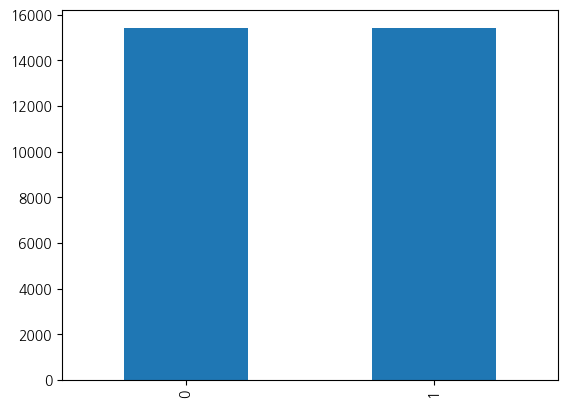

In [ ]:
# 훈련용 데이터의 레이블 분포 확인
train['label'].value_counts().plot(kind = 'bar')
print(train.groupby('label').size().reset_index(name = 'count'))

In [ ]:
# 긍정/부정에 자주 등장하는 단어들 따로 저장해놓기 (명사,형용사 토큰만 사용)
negative_words = np.hstack(train[train.label == 0]['no_ad'].values)
positive_words = np.hstack(train[train.label == 1]['no_ad'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('광고', 6605), ('없다', 2779), ('아니다', 1831), ('진짜', 1212), ('많다', 1182), ('계속', 1155), ('아이템', 1148), ('현질', 1068), ('다시', 992), ('레벨', 950), ('어렵다', 873), ('재밌다', 858), ('재미', 827), ('좋다', 824), ('안되다', 810), ('짜증', 782), ('업데이트', 770), ('이다', 684), ('그냥', 667), ('재미있다', 651)]
[('좋다', 6878), ('재밌다', 5567), ('재미있다', 3723), ('광고', 3443), ('정말', 1619), ('많다', 1554), ('귀엽다', 1491), ('없다', 1448), ('캐릭터', 1304), ('이다', 1188), ('진짜', 1166), ('그렇다', 938), ('레벨', 714), ('추천', 706), ('재미', 699), ('계속', 677), ('다시', 654), ('사람', 637), ('아니다', 629), ('좋아하다', 610)]


긍정 리뷰의 평균 길이 : 11.911666557613033
부정 리뷰의 평균 길이 : 11.109625152703659


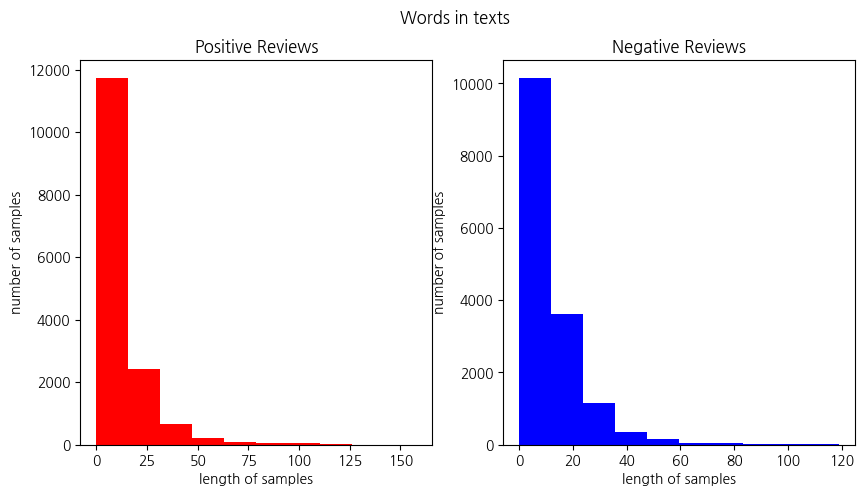

In [ ]:
# 긍정/부정의 길이 분포 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train[train['label']==1]['all'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train[train['label']==0]['all'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

# X(독립), y(종속)로 분리

In [ ]:
X_train = train['all'].values
y_train = train['label'].values
X_test= test['all'].values
y_test = test['label'].values

# 로지스틱 회귀 모델링

## 1. TF-IDF 벡터화

In [ ]:
X_train = [' '.join(x) for x in X_train]
X_train[:5]

['정말 재미나 만의 마을 만들다 매력 이고 섬세하다 디테 일이 좋다',
 '가다 모르다 재미있다 하다 추천 하다',
 '정말 재미있다 그거 아기 키우다 제작자 감사하다',
 '그럭저럭 괜찮다',
 '광고 보다 내용 재밌다 그렇다 알다 재밌다']

In [ ]:
X_test = [' '.join(x) for x in X_test]
X_test[:5]

['정말 정말 재밌다 근데 광고 너무 많이 나오다 주다 이유 마찬가지 예요 광고 정말 많이 나오다 근데 정말 너무 재밌다 중독 성도 강하다 즐겁다 근데 한번 주다 광고 나오다 한번 씻다 광고 나오다 광고 고치다 광고 부탁드리다',
 '생각 보다 재미 너무 어렵다',
 '엄청나다',
 '정말 재밌다 상황 하다 좋다 아쉽다 한국어 돼다 ᅲᅲ 한국판 생기다 좋다',
 '재미있다 인데 어렵다 짜증 나요']

In [ ]:
# TF-IDF 벡터화 객체 생성
tfidf_vectorizer = TfidfVectorizer()  # max_features=1000 : 원하는 최대 특징 수 설정

# 학습 데이터를 TF-IDF 벡터로 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# 테스트 데이터를 TF-IDF 벡터로 변환
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# TF-IDF 벡터의 크기 확인
print("TF-IDF 벡터의 크기 (학습 데이터):", X_train_tfidf.shape)
print("TF-IDF 벡터의 크기 (테스트 데이터):", X_test_tfidf.shape)

TF-IDF 벡터의 크기 (학습 데이터): (30836, 12527)
TF-IDF 벡터의 크기 (테스트 데이터): (7710, 12527)


In [ ]:
vocab = tfidf_vectorizer.vocabulary_
id_to_word = {v: k for k, v in vocab.items()}
print(id_to_word)

{9650: '정말', 9369: '재미나', 4220: '만의', 4134: '마을', 4202: '만들다', 4321: '매력', 8686: '이고', 6244: '섬세하다', 3600: '디테', 9030: '일이', 9914: '좋다', 799: '가다', 4492: '모르다', 9373: '재미있다', 11868: '하다', 10747: '추천', 1889: '그거', 7068: '아기', 11130: '키우다', 9766: '제작자', 971: '감사하다', 1924: '그럭저럭', 1694: '괜찮다', 1668: '광고', 5316: '보다', 2603: '내용', 9379: '재밌다', 1930: '그렇다', 7288: '알다', 7794: '여러', 10848: '친구', 4512: '모이다', 8936: '인데', 7183: '아직', 4508: '모으다', 4764: '미션', 11121: '클리어', 11849: '하고', 8992: '일도', 2573: '낮잠', 9114: '자고', 2864: '느리다', 10281: '진짜', 5463: '부분', 11636: '평가', 8709: '이다', 3520: '드리다', 2377: '끝나다', 4092: '마다', 2458: '나오다', 10199: '지우다', 9273: '잠자다', 4257: '말다', 1294: '겁니다', 9340: '장점', 3033: '단점', 1429: '계속', 6107: '생기다', 5149: '버스', 6208: '선물', 7506: '어떻다', 1018: '강아지', 4687: '물건', 10181: '지면', 1520: '고장', 2445: '나서다', 7996: '오다', 1275: '걸리다', 8253: '요즘', 3548: '들이다', 6548: '순간', 4743: '미니게임', 7284: '않다', 6732: '시간제', 11920: '하트', 5307: '보관', 10008: '주지', 5904: '사용', 2359: '끄다', 11862:

## 2. 모델 학습

In [ ]:
# 모형 적합과 예측
lr = LogisticRegression(random_state = 0)
lr.fit(X_train_tfidf, y_train) # 학습
y_pred = lr.predict(X_test_tfidf) # 예측
# 평가
print(pd.DataFrame({'y':y_test, 'pred':y_pred})) # 실제 값과 예측값 비교
lr.score(X_test_tfidf, y_test)

      y  pred
0     1     1
1     0     0
2     0     1
3     1     1
4     0     0
...  ..   ...
7705  0     0
7706  1     1
7707  0     0
7708  0     0
7709  0     0

[7710 rows x 2 columns]


0.8804150453955901

- 정확도 = 0.88

## 평가 지표 0.880

In [ ]:
# 정확도, 정밀도, 재현율, F1점수
a = accuracy_score(y_test, y_pred)
p = precision_score(y_test, y_pred)
r =recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print('Accuracy: %.3f' % a,', Precision: %.3f' % p, ', Recall: %.3f' % r, ', F1: %.3f' % f1 )

Accuracy: 0.880 , Precision: 0.907 , Recall: 0.851 , F1: 0.878


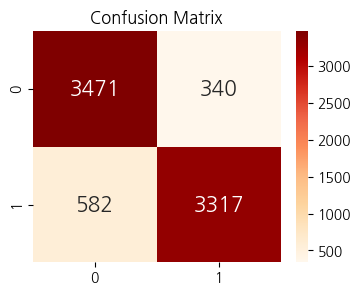

In [ ]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

# LSTM 모델링

In [ ]:
X_train = train['all'].values
y_train = train['label'].values
X_test= test['all'].values
y_test = test['label'].values

## 1. 정수 인코딩

**진행 과정**
- tokenizer = Tokenizer() # 토크나이저 객체 생성
- tokenizer.fit_on_texts(학습데이터) # 단어 집합 생성 + 고유 정수 부여
- tokenizer.word_index # {단어:고유정수}
- tokenizer.word_counts # {단어:빈도수}
- tokenizer = Tokenizer(num_words=단어 집합 크기, oov_token='인코딩 과정에서 지정한 단어집합크기를 넘어선 단어들에게 부여할 문자')
- tokenizer.fit_on_texts(X_train)
- tokenizer.text_to_sequences(학습데이터) # 정수 인코딩
- tokenizer.text_to_sequences(평가데이터)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여

In [ ]:
tokenizer.word_index # .word_index :  생성된 {단어:고유번호} 확인

{'하다': 1,
 '광고': 2,
 '너무': 3,
 '좋다': 4,
 '재밌다': 5,
 '나오다': 6,
 '재미있다': 7,
 '없다': 8,
 '되다': 9,
 '보다': 10,
 '많다': 11,
 '많이': 12,
 '만들다': 13,
 '않다': 14,
 '깔다': 15,
 '돼다': 16,
 '아이템': 17,
 '레벨': 18,
 '현질': 19,
 '꾸미다': 20,
 '하고': 21,
 '주다': 22,
 '귀엽다': 23,
 '캐릭터': 24,
 '재미': 25,
 '자다': 26,
 '깨다': 27,
 '근데': 28,
 '업데이트': 29,
 '어렵다': 30,
 '가다': 31,
 '뜨다': 32,
 '싶다': 33,
 '안되다': 34,
 '인데': 35,
 '사람': 36,
 '모르다': 37,
 '받다': 38,
 'ㅠㅠ': 39,
 '하트': 40,
 '짜증': 41,
 '걸리다': 42,
 '해주다': 43,
 '추천': 44,
 '쓰다': 45,
 '오다': 46,
 '말다': 47,
 '처음': 48,
 'ㅋㅋ': 49,
 '나다': 50,
 '생각': 51,
 '이벤트': 52,
 '시작': 53,
 '삭제': 54,
 '지우다': 55,
 '마다': 56,
 '들다': 57,
 '플레이': 58,
 '줄다': 59,
 '해보다': 60,
 '포우': 61,
 '되어다': 62,
 '고치다': 63,
 '드리다': 64,
 '결제': 65,
 'ㅎㅎ': 66,
 '바꾸다': 67,
 '유도': 68,
 '끄다': 69,
 '진행': 70,
 '들어가다': 71,
 '보상': 72,
 '좋아하다': 73,
 '건지다': 74,
 '모으다': 75,
 '중간': 76,
 '이에요': 77,
 '넘다': 78,
 '가챠': 79,
 '아쉽다': 80,
 '키우다': 81,
 '엄청': 82,
 '감사하다': 83,
 '단계': 84,
 '친구': 85,
 '난이도': 86,
 '사용': 87,
 '보고': 88,
 '써다'

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12483
등장 빈도가 1번 이하인 희귀 단어의 수: 6082
단어 집합에서 희귀 단어의 비율: 48.722262276696306
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8956607384412072


In [ ]:
# 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
vocab_size = total_cnt - rare_cnt + 2  # 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6403


In [ ]:
# 단어 집합의 크기를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
# 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
import pickle

# Tokenizer 저장
with open('/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 2. 패딩

최대값: 150
최소값: 0
평균값: 10.433077523413111
중앙값: 7.0


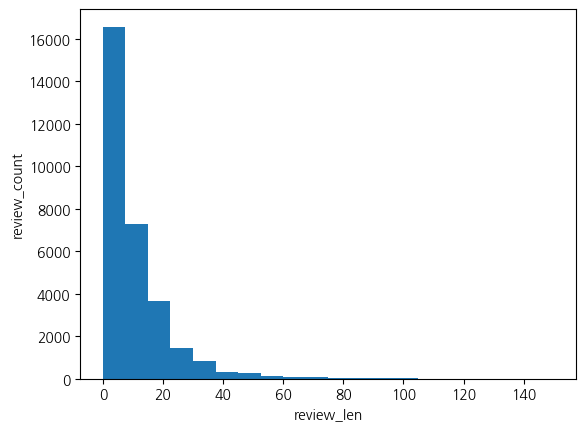

In [ ]:
# X_train_seq에 있는 내부 리스트의 개수(시퀀스 길이)를 반환하여 리스트에 저장
X_train_len = [len(doc) for doc in X_train]

print("최대값:", max(X_train_len))
print("최소값:", min(X_train_len))
print("평균값:", np.mean(X_train_len))
print("중앙값:", np.median(X_train_len))

# 히스토그램으로 리뷰 길이의 분포를 확인해보자!
plt.hist(X_train_len, bins=20)
plt.xlabel('review_len')
plt.ylabel('review_count')
plt.show()

In [ ]:
# max_len으로 패딩할 경우, 완전히 보전할 수 있는지의 비율
def below_threshold_len(max_len, nested_list):
  '''매개변수 : max_len(패딩할 최대 길이), nested_list(학습 시퀀스 데이터)'''
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 110
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 110 이하인 샘플의 비율: 99.98048907388137


- 99.98%가 120이하의 길이를 가지므로, 120로 패딩

In [ ]:
X_train = pad_sequences(X_train, maxlen=110)
X_test = pad_sequences(X_test, maxlen=110)
print(X_train.shape, X_test.shape)

(30752, 110) (7688, 110)


## 3. 모델 학습 Embedding + LSTM

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm2_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로
                         monitor = 'val_acc',   # 파일을 저장할지 결정하는 기준
                         save_best_only = True, # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델을 저장 여부
                         mode = 'max',          # save_best_only가 True일 경우, 갱신 값의 최대,최소를 결정(디폴드가 max)
                         verbose = 1            # 모델 개선 및 저장 메시지를 출력방식(0,1,2)
                         )
f_early = EarlyStopping(monitor = 'val_acc',
                        patience = 5 # monitor의 값 개선을 몇 번이나 기다려줄지를 결정
                        )

# 신경망 모델 구조 설계
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
  # Embedding의 매개변수 설명
  # model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    # input_dim : 단어사전 크기 (=유일한 단어의 수)
    # output_dim : 임베딩 차원, (각 단어를 나타내는 벡터의 크기)
    # input_length : 입력 시퀀스의 길이 (->모든 시퀀스를 동일한 길이로 패딩)
model.add(LSTM(128, input_shape=(120,embedding_dim), return_sequences=True))
  # 첫번째 LSTM의 매개변수 설명
  # model.add(LSTM(히든 유닛 수, input_shape=(max_sequence_length, embedding_dim)))
    # input_shape : (입력 시퀀스의 길이=tiemstemps=반복수, 각 시퀀스 요소의 특성 수=input_dim)
    # return_sequences=True : LSTM을 여러 층 할 경우, 출력을 시퀀스로 반환
model.add(LSTM(256))
  # 일반적으로 첫 번째 LSTM 층의 hidden units 수는 상대적으로 적게 설정하고, 이후의 층에서는 점차 증가시키는 것이 일반적인 방법
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

h = model.fit(X_train, y_train,
              validation_split=0.2,
              batch_size=128,
              epochs=100,
              callbacks = [f_mckp, f_early])

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 0.4025 - acc: 0.8152
Epoch 1: val_acc improved from -inf to 0.88116, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm2_001_0.8812.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


193/193 [==============================] - 323s 2s/step - loss: 0.4025 - acc: 0.8152 - val_loss: 0.3031 - val_acc: 0.8812
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 0.3833 - acc: 0.8391
Epoch 2: val_acc did not improve from 0.88116
193/193 [==============================] - 284s 1s/step - loss: 0.3833 - acc: 0.8391 - val_loss: 0.3057 - val_acc: 0.8766
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 0.2470 - acc: 0.9031
Epoch 3: val_acc did not improve from 0.88116
193/193 [==============================] - 303s 2s/step - loss: 0.2470 - acc: 0.9031 - val_loss: 0.3139 - val_acc: 0.8760
Epoch 4/100
193/193 [==============================] - ETA: 0s - loss: 0.2237 - acc: 0.9146
Epoch 4: val_acc did not improve from 0.88116
193/193 [==============================] - 304s 2s/step - loss: 0.2237 - acc: 0.9146 - val_loss: 0.3113 - val_acc: 0.8771
Epoch 5/100
193/193 [==============================] - ETA: 0s - loss: 0.2042 - acc: 0.9228
Epoch 

In [ ]:
#################### lstm3 : 데이터 전처리 과정 추가
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm3_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로
                         monitor = 'val_acc',   # 파일을 저장할지 결정하는 기준
                         save_best_only = True, # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델을 저장 여부
                         mode = 'max',          # save_best_only가 True일 경우, 갱신 값의 최대,최소를 결정(디폴드가 max)
                         verbose = 1            # 모델 개선 및 저장 메시지를 출력방식(0,1,2)
                         )
f_early = EarlyStopping(monitor = 'val_acc',
                        patience = 5 # monitor의 값 개선을 몇 번이나 기다려줄지를 결정
                        )

# 신경망 모델 구조 설계
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(LSTM(128, input_shape=(120,embedding_dim), return_sequences=True))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

h = model.fit(X_train, y_train,
              validation_split=0.2,
              batch_size=128,
              epochs=100,
              callbacks = [f_mckp, f_early])

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 0.3738 - acc: 0.8324
Epoch 1: val_acc improved from -inf to 0.88716, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm3_001_0.8872.hdf5
193/193 [==============================] - 342s 2s/step - loss: 0.3738 - acc: 0.8324 - val_loss: 0.2771 - val_acc: 0.8872
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


193/193 [==============================] - ETA: 0s - loss: 0.2318 - acc: 0.9109
Epoch 2: val_acc improved from 0.88716 to 0.88878, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm3_002_0.8888.hdf5
193/193 [==============================] - 324s 2s/step - loss: 0.2318 - acc: 0.9109 - val_loss: 0.2786 - val_acc: 0.8888
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 0.2100 - acc: 0.9212
Epoch 3: val_acc did not improve from 0.88878
193/193 [==============================] - 325s 2s/step - loss: 0.2100 - acc: 0.9212 - val_loss: 0.2868 - val_acc: 0.8875
Epoch 4/100
193/193 [==============================] - ETA: 0s - loss: 0.1816 - acc: 0.9341
Epoch 4: val_acc did not improve from 0.88878
193/193 [==============================] - 324s 2s/step - loss: 0.1816 - acc: 0.9341 - val_loss: 0.3181 - val_acc: 0.8849
Epoch 5/100
193/193 [==============================] - ETA: 0s - loss: 0.1676 - acc: 0.9374
Epoch 5: val

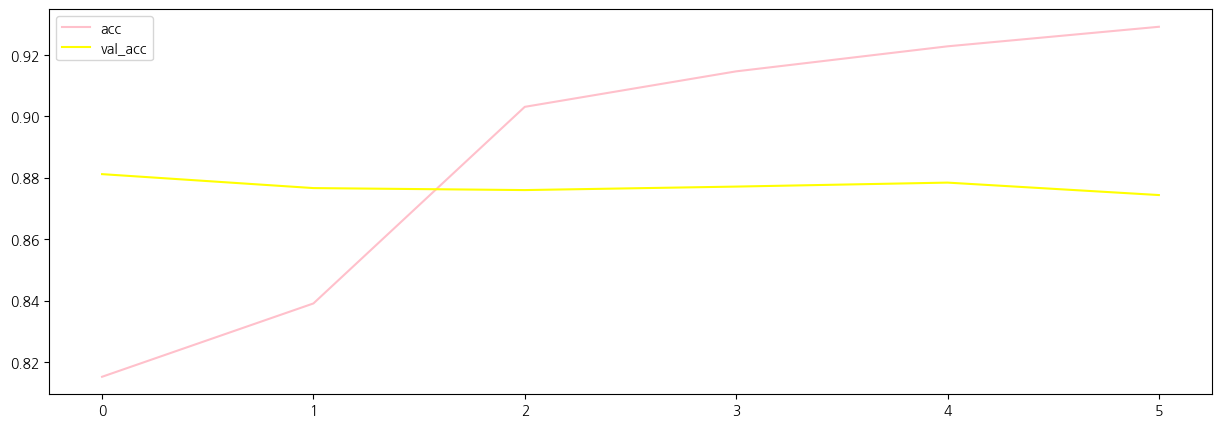

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'], label='acc', color='pink')
plt.plot(h.history['val_acc'], label='val_acc', color='yellow')

plt.legend()
plt.show()

## 평가 0.8938

In [ ]:
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm3_002_0.8888.hdf5')

pre = best_model.predict(X_test)   # 예측값 구하기 (각 클래스에 대한 확률)
y_pred = (best_model.predict(X_test) > 0.5).astype(int) # 0.5보다 크면 1, 아니면 0

print(classification_report(y_test, y_pred))

241/241 [==============================] - 45s 188ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.89      3810
           1       0.91      0.87      0.89      3900

    accuracy                           0.89      7710
   macro avg       0.89      0.89      0.89      7710
weighted avg       0.89      0.89      0.89      7710



In [ ]:
print("테스트 정확도: %.4f" % (best_model.evaluate(X_test, y_test)[1]))

241/241 [==============================] - 47s 190ms/step - loss: 0.2722 - acc: 0.8938
테스트 정확도: 0.8938


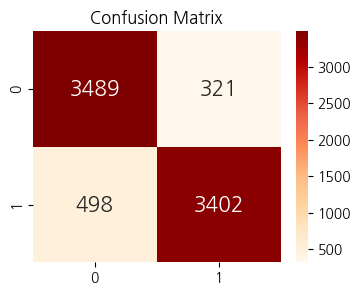

In [ ]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

# BiLSTM 모델링
- 양방향 LSTM 모델링
- LSTM 모델링 시 정수인코딩 작업 다시 한 후, 모델링하기

## 모델 학습 Embedding + BiLSTM

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm7_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로
                         monitor = 'val_acc',   # 파일을 저장할지 결정하는 기준
                         save_best_only = True, # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델을 저장 여부
                         mode = 'max',          # save_best_only가 True일 경우, 갱신 값의 최대,최소를 결정(디폴드가 max)
                         verbose = 1            # 모델 개선 및 저장 메시지를 출력방식(0,1,2)
                         )
f_early = EarlyStopping(monitor = 'val_acc',
                        patience = 5 # monitor의 값 개선을 몇 번이나 기다려줄지를 결정
                        )

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=30, callbacks=[f_early, f_mckp], batch_size=256, validation_split=0.2)


Epoch 1/30
97/97 [==============================] - ETA: 0s - loss: 0.5537 - acc: 0.7394
Epoch 1: val_acc improved from -inf to 0.86132, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm7_001_0.8613.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 127s 1s/step - loss: 0.5537 - acc: 0.7394 - val_loss: 0.3789 - val_acc: 0.8613
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 0.3005 - acc: 0.8841
Epoch 2: val_acc did not improve from 0.86132
97/97 [==============================] - 119s 1s/step - loss: 0.3005 - acc: 0.8841 - val_loss: 0.3843 - val_acc: 0.8111
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 0.2483 - acc: 0.9033
Epoch 3: val_acc improved from 0.86132 to 0.89709, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm7_003_0.8971.hdf5
97/97 [==============================] - 120s 1s/step - loss: 0.2483 - acc: 0.9033 - val_loss: 0.2706 - val_acc: 0.8971
Epoch 4/30
97/97 [==============================] - ETA: 0s - loss: 0.2243 - acc: 0.9127
Epoch 4: val_acc did not improve from 0.89709
97/97 [==============================] - 129s 1s/step - loss: 0.2243 - acc: 0.9127 - val_loss: 0.2676 - v

## 평가 0.904

In [ ]:
###########################
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm7_010_0.9090.hdf5')

pre = best_model.predict(X_test)   # 예측값 구하기 (각 클래스에 대한 확률)
y_pred = (pre > 0.5).astype(int) # 0.5보다 크면 1, 아니면 0

print(classification_report(y_test, y_pred))

241/241 [==============================] - 24s 94ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3832
           1       0.91      0.90      0.90      3856

    accuracy                           0.90      7688
   macro avg       0.90      0.90      0.90      7688
weighted avg       0.90      0.90      0.90      7688



In [ ]:
print("테스트 정확도: %.4f" % (best_model.evaluate(X_test, y_test)[1]))

241/241 [==============================] - 24s 93ms/step - loss: 0.2654 - acc: 0.9036
테스트 정확도: 0.9036


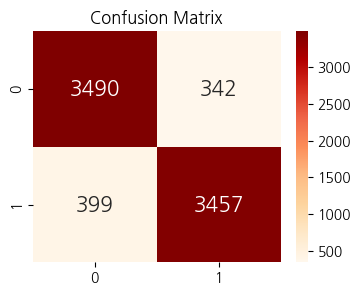

In [ ]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

# LSTM + GRU

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm_gru3_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로
                         monitor = 'val_acc',   # 파일을 저장할지 결정하는 기준
                         save_best_only = True, # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델을 저장 여부
                         mode = 'max',          # save_best_only가 True일 경우, 갱신 값의 최대,최소를 결정(디폴드가 max)
                         verbose = 1            # 모델 개선 및 저장 메시지를 출력방식(0,1,2)
                         )
f_early = EarlyStopping(monitor = 'val_acc',
                        patience = 5 # monitor의 값 개선을 몇 번이나 기다려줄지를 결정
                        )

# 신경망 모델 구조 설계
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))

model.add(LSTM(128, input_shape=(120,embedding_dim), return_sequences=True))
model.add(GRU(128, return_sequences=True)) # GRU 층 추가

model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

h = model.fit(X_train, y_train,
              validation_split=0.2,
              batch_size=128,
              epochs=100,
              callbacks = [f_mckp, f_early])

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 0.3785 - acc: 0.8269
Epoch 1: val_acc improved from -inf to 0.88846, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm_gru3_001_0.8885.hdf5
193/193 [==============================] - 404s 2s/step - loss: 0.3785 - acc: 0.8269 - val_loss: 0.2845 - val_acc: 0.8885
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


193/193 [==============================] - ETA: 0s - loss: 0.2336 - acc: 0.9111
Epoch 2: val_acc improved from 0.88846 to 0.89202, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm_gru3_002_0.8920.hdf5
193/193 [==============================] - 400s 2s/step - loss: 0.2336 - acc: 0.9111 - val_loss: 0.2824 - val_acc: 0.8920
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 0.1975 - acc: 0.9245
Epoch 3: val_acc did not improve from 0.89202
193/193 [==============================] - 401s 2s/step - loss: 0.1975 - acc: 0.9245 - val_loss: 0.2897 - val_acc: 0.8865
Epoch 4/100
193/193 [==============================] - ETA: 0s - loss: 0.1752 - acc: 0.9340
Epoch 4: val_acc did not improve from 0.89202
193/193 [==============================] - 397s 2s/step - loss: 0.1752 - acc: 0.9340 - val_loss: 0.2946 - val_acc: 0.8873
Epoch 5/100
193/193 [==============================] - ETA: 0s - loss: 0.1569 - acc: 0.9432
Epoch 5:

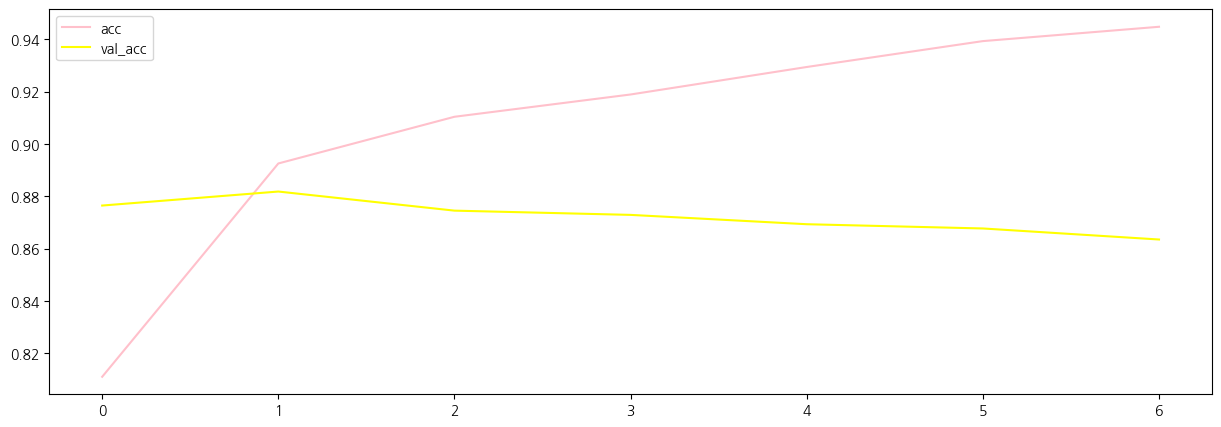

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'], label='acc', color='pink')
plt.plot(h.history['val_acc'], label='val_acc', color='yellow')

plt.legend()
plt.show()

## 평가 0.887

In [ ]:
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/lstm_gru2_002_0.8818.hdf5')

pre = best_model.predict(X_test)   # 예측값 구하기 (각 클래스에 대한 확률)
y_pred = (pre > 0.5).astype(int) # 0.5보다 크면 1, 아니면 0

print(classification_report(y_test, y_pred))

241/241 [==============================] - 67s 271ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3811
           1       0.92      0.85      0.88      3899

    accuracy                           0.89      7710
   macro avg       0.89      0.89      0.89      7710
weighted avg       0.89      0.89      0.89      7710



In [ ]:
print("테스트 정확도: %.4f" % (best_model.evaluate(X_test, y_test)[1]))

241/241 [==============================] - 65s 266ms/step - loss: 0.3011 - acc: 0.8866
테스트 정확도: 0.8866


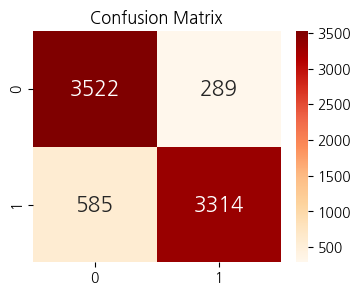

In [ ]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

# BiLSTM + GRU

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm_gru3_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,  # 파일 경로
                         monitor = 'val_acc',   # 파일을 저장할지 결정하는 기준
                         save_best_only = True, # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델을 저장 여부
                         mode = 'max',          # save_best_only가 True일 경우, 갱신 값의 최대,최소를 결정(디폴드가 max)
                         verbose = 1            # 모델 개선 및 저장 메시지를 출력방식(0,1,2)
                         )
f_early = EarlyStopping(monitor = 'val_acc',
                        patience = 5 # monitor의 값 개선을 몇 번이나 기다려줄지를 결정
                        )

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True))) # Bidirectional LSTM을 사용
model.add(GRU(128))  # GRU 층
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, callbacks=[f_early, f_mckp], batch_size=256, validation_split=0.2)


Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 0.4579 - acc: 0.7749
Epoch 1: val_acc improved from -inf to 0.86641, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm_gru3_001_0.8664.hdf5
97/97 [==============================] - 247s 2s/step - loss: 0.4579 - acc: 0.7749 - val_loss: 0.3236 - val_acc: 0.8664
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - ETA: 0s - loss: 0.2975 - acc: 0.8807
Epoch 2: val_acc improved from 0.86641 to 0.88359, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm_gru3_002_0.8836.hdf5
97/97 [==============================] - 233s 2s/step - loss: 0.2975 - acc: 0.8807 - val_loss: 0.3022 - val_acc: 0.8836
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.2597 - acc: 0.8989
Epoch 3: val_acc improved from 0.88359 to 0.89640, saving model to /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm_gru3_003_0.8964.hdf5
97/97 [==============================] - 233s 2s/step - loss: 0.2597 - acc: 0.8989 - val_loss: 0.2744 - val_acc: 0.8964
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.2635 - acc: 0.9008
Epoch 4: val_acc did not improve from 0.89640
97/97 [==============================] - 233s 2s/step - loss: 0.2635 - acc: 0.9008 - val_loss: 0

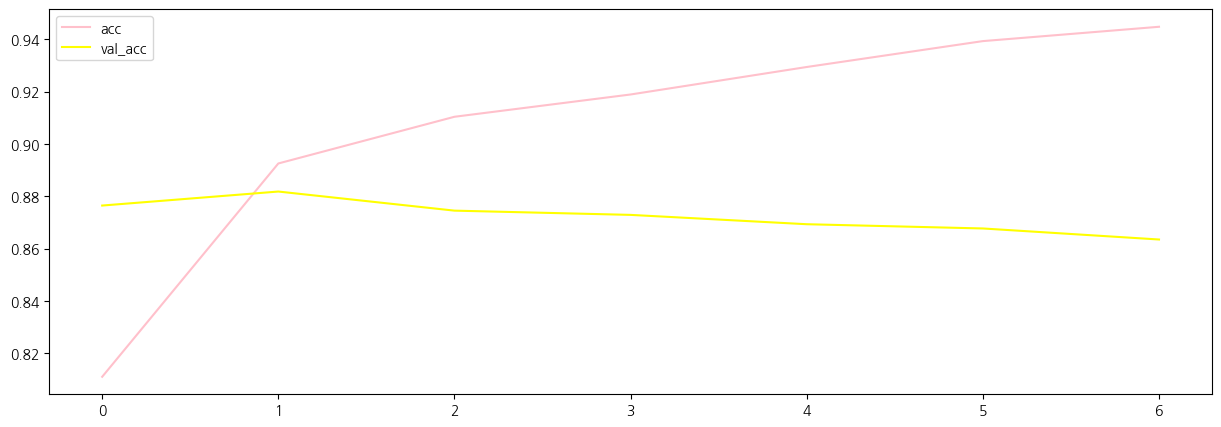

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'], label='acc', color='pink')
plt.plot(h.history['val_acc'], label='val_acc', color='yellow')

plt.legend()
plt.show()

## 평가 0.892

In [ ]:
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/Re:Source/model/bilstm_gru3_003_0.8964.hdf5')

pre = best_model.predict(X_test)   # 예측값 구하기 (각 클래스에 대한 확률)
y_pred = (pre > 0.5).astype(int) # 0.5보다 크면 1, 아니면 0

print(classification_report(y_test, y_pred))

241/241 [==============================] - 46s 186ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3810
           1       0.92      0.87      0.89      3900

    accuracy                           0.89      7710
   macro avg       0.89      0.89      0.89      7710
weighted avg       0.89      0.89      0.89      7710



In [ ]:
print("테스트 정확도: %.4f" % (best_model.evaluate(X_test, y_test)[1]))

241/241 [==============================] - 46s 184ms/step - loss: 0.2702 - acc: 0.8921
테스트 정확도: 0.8921


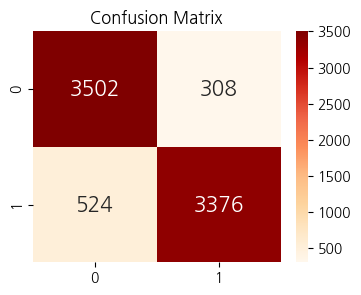

In [ ]:
# 추정결과 confusion matrix
c_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(c_mat, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

# 모델링 정확도 비교
- 로지스틱 회귀 : 0.880
- LSTM : 0.894
- BiLSTM : 0.904
- LSTM + GRU : 0.887
- BiLSTM + GRU : 0.892
<br><br>

**BiLSTM > LSTM > BiLSTM+GRU > LSTM+GRU > 로지스틱회귀**
<br><br>
=> BiLSTM 모델 선택!